In [ ]:
# this cell made executed if you need install the extern packages.
# all the others packages are included in the Anaconda 
!pip install folium

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# this package is extern from Jupyter Notebook
# it is used to create maps. It's so cool. Try it!
import folium

In [2]:
# in this CELL I test if all files are in the correct directory
try:
    list_tripFiles = ['dataFiles/data-sample_data-nyctaxi-trips-2009-json_corrigido.json',
                      'dataFiles/data-sample_data-nyctaxi-trips-2010-json_corrigido.json',
                      'dataFiles/data-sample_data-nyctaxi-trips-2011-json_corrigido.json',
                      'dataFiles/data-sample_data-nyctaxi-trips-2012-json_corrigido.json']
    
    for file in list_tripFiles:
        os.path.isfile(file)
        
    vendorsFile = 'dataFiles/data-vendor_lookup-csv.csv'
    dfDataVendors = pd.read_csv(vendorsFile)
    
    # this file contain the all types of payment
    # I don't understand why uses it, but I open it. Maybe in future...
    paymentModes = 'dataFiles/data-payment_lookup-csv.csv'
    dfPaymentModes = pd.read_csv(paymentModes)
        
except:
    print("Não foi possível abrir algum dos arquivos. Verifique se TODOS estão na pasta correta ['/dataFiles']!")

    

In [3]:
# this is the first function.
# it will receive one list with the '.json' files names, open each one and append all them in a big Pandas DataFrame

def createBigDF(list_files):
    
    # the big DataFrame
    dfAllFiles = pd.DataFrame()
    
    for file in list_files:
        dfOneFile = pd.read_json(file)
        dfAllFiles = dfAllFiles.append(dfOneFile, ignore_index=True)
        
    return dfAllFiles




In [4]:
# this function answers the first question: 
    # Qual a distância média percorrida por viagens com no máximo 2 passageiros.
    

def meanDistance(list_DataTrips):
    
    # call the function "createBigDF" to get one DataFrame with all json files
    dfDataTrips = createBigDF(list_DataTrips)   
    
    # create a new DataFrame with a filter in 'passenger_count' column
    dfPassengers = dfDataTrips.query('passenger_count <= 2')
    
    # get the mean of travelled distance. Using the filter above and all trips 
    dfMeanTotal = np.mean(dfDataTrips['trip_distance'])
    dfMeanPass = np.mean(dfPassengers['trip_distance'])
    
    dfMeanTotal = round(dfMeanTotal, 2)
    dfMeanPass = round(dfMeanPass, 2)
    
    # here start the chart
    # create two arrays with numpy function (with and without filter)
    x = np.array(["Qualquer Nº de Passageiros", "2 ou menos Passageiros"])
    y = np.array([dfMeanTotal, dfMeanPass])
    
    # passing datas to plt function make the chart
    plt.xlabel("Número de Passageiros")
    plt.ylabel("Distância Média da Corrida")
    
    # this two line bellow add a description in the top of each bar.
    # is not the best way to make this, because exist the method bar_label for this, 
    # but it only exists in 3.4 version from Matplotlib and younger.
    # I updated my Anaconda environment and the MatPlotLib, but it not received this version. I don't know why.
    plt.annotate(y[0], (-0.05, y[0])) 
    plt.annotate(y[1], (0.95, y[1]))
    
    plt.bar(x, y, color='blue', alpha=0.75, width=0.5)   
    plt.show()
    

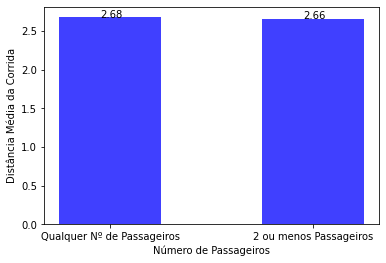

In [5]:
# call function to answear the question 1.
meanDistance(list_tripFiles)

In [6]:
# this is the second function. It try answear the second question...
    # Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado.
    
# this question can have three answears. 
    #1 Count only Cash payment
    #2 Count only fares and surcharges (without tips and tolls)
    #3 Count the total amount
# here I will uses the second and third counts way

def bigVendors(dfVendors, list_DataTrips):
    
    # get DataFrame from json Files
    dfTrips = createBigDF(list_DataTrips)
    
    # get the quantity of Vendors in file 'data-vendor_lookup-csv.csv' (received in the function parameter)
    total_vendors = len(dfVendors)
    
    # create a empty DataFrame to add datas of search
    df_big_vendors = pd.DataFrame()
    df_big_vendors['Alias'] = dfVendors['vendor_id']
    df_big_vendors['Name'] = dfVendors['name']
    
    # create two empty list to add amount of each search in loop
    list_amount = []
    list_fare_amount = []
    
    i = 0
    while i < total_vendors:
        
        # get vendor_id and uses it to filter only trips of the respective vendor
        vendor = dfVendors["vendor_id"][i]
        dfVendor = dfTrips.query(f'vendor_id == "{vendor}"')
        
        # so, sum the amount of all trips, in the two ways mentioned above
        dfSumVendor = np.sum(dfVendor['total_amount']).round(2)
        list_amount.append(int(dfSumVendor))
        
        dfSumFares = np.sum(dfVendor['fare_amount'] + dfVendor['surcharge']).round(2)
        list_fare_amount.append(int(dfSumFares))
        
        i += 1
        
    # add sums lists in DataFrame, each in different column    
    df_big_vendors['Amount'] = list_amount
    df_big_vendors['Fare_Amount'] = list_fare_amount
    
    df_big_vendors = df_big_vendors.nlargest(3, 'Amount') # get only three biggest vendors
    
    x = np.arange(len(df_big_vendors['Name']))  # the label locations
    width = 0.35  # the width of the bars
    
    # create the group bars chart
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, df_big_vendors['Amount'], width, label='Faturamento Total')
    rects2 = ax.bar(x + width/2, df_big_vendors['Fare_Amount'], width, label='Somente Tarifas')

    # Add some text for labels, title and custom x-axis tick labels
    ax.set_ylabel('Faturamento')
    ax.set_title('Maiores Companhias em Faturamento')
    ax.set_xticks(x)
    ax.set_xticklabels(df_big_vendors['Name'])
    ax.legend()
    
    plt.xticks(rotation=30)
    fig.tight_layout()
    plt.show()


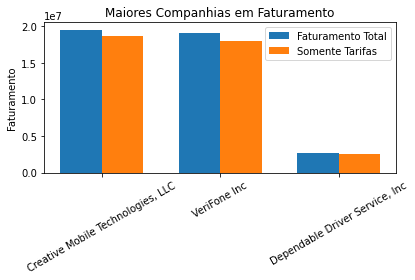

In [7]:
# call the function above
bigVendors(dfDataVendors, list_tripFiles)

In [11]:
# here is the function to answear the following question:
    # Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro.

def histogramCash(list_DataTrips):
    
    # get the complete DataFrame and convert the column with string datetime datas to datetime
    dfDataTrips = createBigDF(list_DataTrips)   
    dfDataTrips['pickup_datetime'] = pd.to_datetime(dfDataTrips['pickup_datetime'])
    
    # filter to get only CASH payment type 
    dfCashTrips = dfDataTrips.query('payment_type == "CASH" | payment_type == "Cash"')
    
    # Create a empty DataFrame and list
    df_count_cash_trips = pd.DataFrame()
    list_count_trips = []
    
    # I create a variable month to iterate in while loop
    # I made this to separate all datas in months, to show in histogram chart
    year = 2009
    while year <= 2012:
        month = 1
        dfYearTrips = dfCashTrips.query('pickup_datetime.dt.year == @year')
        while month <= 12:

            # filter only of iterate month and count trips, so add in list
            trips = dfYearTrips.query('pickup_datetime.dt.month == @month')
            count_trips = np.count_nonzero(trips['pickup_datetime'])
            list_count_trips.append(count_trips)
            month += 1
        year += 1
    
    # add the list in DataFrame
    df_count_cash_trips['Total_trips'] = list_count_trips

    # create datas to chart
    y = np.array(df_count_cash_trips['Total_trips'])

    plt.ylabel("Quantidade de Meses")
    plt.xlabel("Total Recebido em Dinheiro")
    plt.title('Histograma de Faturamento Mensal')
    plt.hist(y, 20, facecolor='g', alpha=0.75)
    plt.xticks(rotation=45)
    plt.show()
    


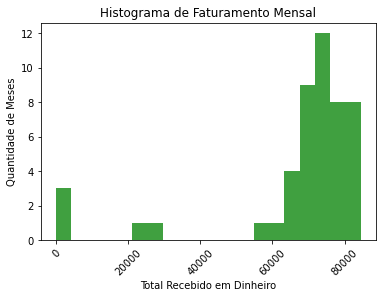

In [12]:
# call function to make a histogram
histogramCash(list_tripFiles)

In [15]:
# this is the fourth function. For me, the most difficult
# it will answear the following question:
    # Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.
def timeSeries(dfDataTrips2012):
    
    # get only file from 2012 year and convert column to datetime format
    dfDataTrips2012['pickup_datetime'] = pd.to_datetime(dfDataTrips2012['pickup_datetime'])
    
    # get datas from months Oct, Nov and Dec (bigger than 9), and where exist tips
    df_tips = dfDataTrips2012.query("pickup_datetime.dt.month > 9 & tip_amount > 0")

    month = 10 # control variable of each month
    dict_diary_tips = {}
    list_days = []
    list_tips = []
    # this loop will iterate three times, in three last months of 2012
    while month <= 12:
        
        day = 1
        # this internal loop will iterate in each day
        while day <= 31:
            list_days.append((str(month)+"-"+str(day)))
            
            # November don't have 31 days, so, add '0' in the list
            if month == 11 and day == 31:
                list_tips.append(0)
            else:
                # count the amount of tips in the respective day
                diary_tips = df_tips.query(f"pickup_datetime.dt.month == {month} & pickup_datetime.dt.day == {day}")
                list_tips.append(len(diary_tips.index))

            day += 1
        # I decided add the lists in a dictionary because is easier add new elemments
        # so add in the next pass the dictionary in the DataFrame
        dict_diary_tips["Dias"] = list_days
        dict_diary_tips["Gorgetas"] = list_tips
        month += 1

    df_diary_tips = pd.DataFrame(dict_diary_tips)

    # start format the DataFrame to create a chart
    df_diary_tips = df_diary_tips.set_index('Dias')
    df_diary_tips.plot()
    
    # define the time series chart form
    plt.tight_layout()
    
    # get the decompose of DataFrame, and add each one in a different variable  
    resultado = seasonal_decompose(df_diary_tips["Gorgetas"], period=12, extrapolate_trend='freq')
    tendencia = resultado.trend
    sazonalidade = resultado.seasonal
    residuo = resultado.resid
    
    # all the four charts are very similar, so decided put them in a for loop
    list_seasonal =[['Série Temporal', 'b'],['Tendência', 'r'], ['Sazonalidade', 'y'], ['Resíduo', 'g']]
    
    s = 0
    for seasonal in list_seasonal:
    
        plt.xlabel('Meses-Dias')
        plt.xticks([])
        plt.ylabel('Quantidade de Gorgetas')
        plt.title(seasonal[0])
        
        if s == 0:
            plt.show()
        elif s == 1:
            plt.plot(tendencia, color=seasonal[1])
        elif s == 2:
            plt.plot(sazonalidade, color=seasonal[1])
        else:
            plt.plot(residuo, color=seasonal[1])
        
        plt.show()
        s += 1
    

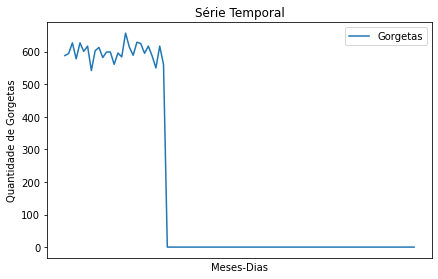

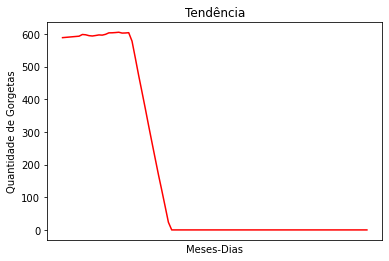

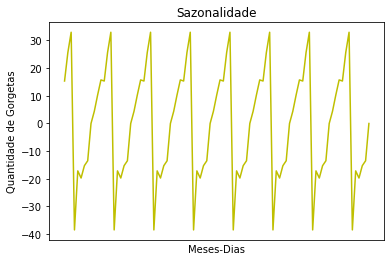

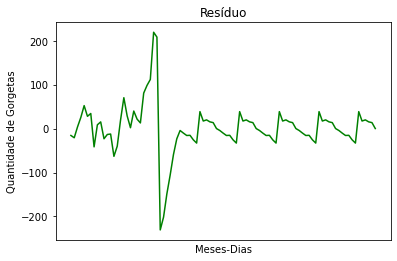

In [16]:
# get json file from 2012 year and call the function
dfDataTrips12 = pd.read_json(list_tripFiles[3])
timeSeries(dfDataTrips12)

In [23]:
# this is the fifth function, that will answear the following question:
    # Qual o tempo médio das corridas nos dias de sábado e domingo;

def timeRunsWeekend(list_DataTrips):
    
    dfDataTrips = createBigDF(list_DataTrips)
    
    # convert the two columns with dates to correct datetime format
    dfDataTrips['pickup_datetime'] = pd.to_datetime(dfDataTrips['pickup_datetime'])
    dfDataTrips['dropoff_datetime'] = pd.to_datetime(dfDataTrips['dropoff_datetime'])
    
    # create three DataFrames, to separate trips from work days, saturdays and sundays
    dfSundayTrips = dfDataTrips.query("pickup_datetime.dt.dayofweek == 6")
    dfSaturdayTrips = dfDataTrips.query("pickup_datetime.dt.dayofweek == 5")
    dfWorkdayTrips = dfDataTrips.query("pickup_datetime.dt.dayofweek <= 4")
    
    # create a dictionary to add only the mean of time trip from each dataframe above
    # for this, I uses the mean method from numpy package
    dict_timeTrips = {}
    dict_timeTrips['work_time_trip'] = np.mean(dfWorkdayTrips['dropoff_datetime'] - dfWorkdayTrips['pickup_datetime'])
    dict_timeTrips['sat_time_trip'] = np.mean(dfSaturdayTrips['dropoff_datetime'] - dfSaturdayTrips['pickup_datetime'])
    dict_timeTrips['sun_time_trip'] = np.mean(dfSundayTrips['dropoff_datetime'] - dfSundayTrips['pickup_datetime'])

    # the return of numpy mean is a timedelta format. It's complicate work with this.
    # so, I convert to string and then I convert to float
    str_meanWork = str(dict_timeTrips['work_time_trip'])    
    str_meanSat = str(dict_timeTrips['sat_time_trip'])
    str_meanSun = str(dict_timeTrips['sun_time_trip'])
    
    cut_meanWork = float(str_meanWork[10:12] + '.' + str_meanWork[13:15])
    cut_meanSat = float(str_meanSat[10:12] + '.' + str_meanSat[13:15])
    cut_meanSun = float(str_meanSun[10:12] + '.' + str_meanSun[13:15])
    
    # create arrays to axis of chart    
    x = np.array(["Dias Úteis", "Sábados", "Domingos"])
    y = np.array([cut_meanWork, cut_meanSat, cut_meanSun])   
    
    # create more one bealtiful chart
    plt.xlabel("Separação de Dias")
    plt.ylabel("Tempo Médio da Corrida (Minutos)")
    plt.annotate(y[0], (-0.05, y[0]))
    plt.annotate(y[1], (0.95, y[1]))
    plt.annotate(y[2], (1.95, y[2]))
    plt.bar(x, y, width=0.5)
    
    plt.show()
    

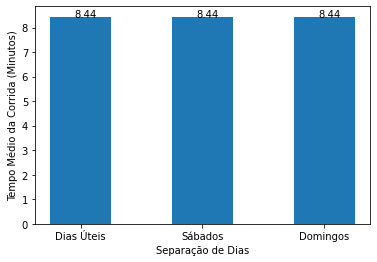

In [24]:
# call the function above
timeRunsWeekend(list_tripFiles)

In [25]:
# here the code stop to uses separated functions
# It get the json trips file of 2010 year and add a dataframe, again
dfDataTrips10 = pd.read_json(list_tripFiles[1])

In [27]:
# this is coolest function (I guess) from my code.

# first, create a map from ny city, with zoom start 11. A view almost complete from city
map_ny = folium.Map(location=[40.74295,-74.004114],zoom_start=11)

# this is a loop to add markers from trips, pickups and dropoff
# I don't send all dataFrame because my PC can't handle this quantity of datas
i = 0
while i <= 100:
    
    # first, get all latitudes and longitudes from pickups and dropoff and add separate variable
    lat_in = dfDataTrips10.loc[i]['pickup_latitude']
    lat_out = dfDataTrips10.loc[i]['dropoff_latitude']
    long_in = dfDataTrips10.loc[i]['pickup_longitude']
    long_out = dfDataTrips10.loc[i]['dropoff_longitude']
    
    # add marker from pickup
    folium.Marker(
            [lat_in,long_in],
            popup='<i>Pickup Place</i>', 
            tooltip=i,
            icon=folium.Icon(color='red')
            ).add_to(map_ny)
    
    # add marker from dropoff
    folium.Marker(
            [lat_out,long_out],
            popup='<i>DropOff Place</i>', 
            tooltip=i,
            icon=folium.Icon(color='green')
            ).add_to(map_ny)
    i += 1

map_ny